In [ ]:
## COVID Group: **Can COVID Case and Death Data Aid in Predicting the Rise and Fall in Stocks**
### Sam Clark, Mahshad Farnoush, Jagadeesh Meesala, Lily Northcutt, Mengxi Shen
### November 20, 2020
### DATA602

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
# ! pip install pandas_datareader
import pandas_datareader.data as web

from sklearn.model_selection import train_test_split as tts
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import classification_report

from sklearn import metrics

import seaborn as sns

# Part 1: Importing COVID Data
## I. Extracting Data
The COVID data we use was gathered from the CDC. The data was taken from January 22, 2020 until November 2, 2020. The data is organized by data, with the following features:
1. Total Cases
2. New Cases
3. Total Death
4. New Deaths

## II. Missing Data and Cleaning
There was no missing data in this dataset (as seen below for covid.info()). However, since we know that we do not have stocks for everyday, we decide to group our data weekly. 

## III. Structure of Dataset
Our COVID dataset looks as follows:
- Each row corresponds to a week
- There are six columns (in addition to date) in our dataset:
    - Total Cases: a sum over the week
    - New Cases: a sum over the week
    - Total Deaths: a sum over the week
    - New Deaths: a sum over the week
    - Change in Cases
    - Change in Deaths
- There are 42 rows (weeks) that we are considering

In [5]:
## COVID Data
# Downloading Data
rawCovid = pd.read_csv("covid.csv")
variables = ["submission_date", "tot_cases", "new_case", "tot_death", "new_death"]
covid = rawCovid.loc[:,variables]
covid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   submission_date  1000 non-null   object 
 1   tot_cases        1000 non-null   int64  
 2   new_case         1000 non-null   float64
 3   tot_death        1000 non-null   int64  
 4   new_death        1000 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 39.2+ KB


In [6]:
# Sum of Week and Adding the difference features
covid["submission_date"] = pd.to_datetime(covid["submission_date"])
covid.rename(columns={"submission_date":"Date"}, inplace=True)

weeklyCovid = covid.groupby(pd.Grouper(key = "Date", freq ="W")).sum()
weeklyCovid.reset_index(inplace=True)

weeklyCovid["case_change"] = weeklyCovid["tot_cases"].diff().fillna(0)
weeklyCovid["death_change"] = weeklyCovid["tot_death"].diff().fillna(0)
weeklyCovid["death_change"].fillna(0, inplace=True)

weeklyCovid.head()

weeklyCovid.to_csv("weeklyCovid.csv")

# Part 2: Stock Data
## I. Choosing our Stocks
We are considering stocks from 9 different industries:
- Bio
- Pharm
- Tech
- Energy
- Retail
- Consumer
- Utility
- Real Estate
- Healthcare

To inform our decision on which stocks we chose to use for each industry, we used a correlation table/heat map to choose between 3-5 stocks. We want to choose uncorrelated stocks so that we capture the behavior of the market, while using less stocks. Additionally, this may help with fitting our model because if we have many highly correlated stocks, the model may only focus in on this and disproportionately favor these stock outcomes.

## II. Extracting our Data
For all of our stocks we are getting our data from Yahoo Finance.

## III. Missing Data and Cleaning
There are approxiamtely 252 trading days in a year. This means that we are missing data, however since we know this data is not missing at random we can comfortably trust our data. Additionally, to deal with these missing days (and some of the volatility of the stock market) we are using an average over the week.

## Structure of Data
We have added stock type: there is a column where the category types are strings, and a column where they are numbers. The category feature is very important for when it comes to constructing our classifier. We have also labeled our data. The label refers to whether the stock rose or fell that week (compared to the week before). Combining the stock and covid datasets together, based on dates, the columns in our dataset are as follows:
- Adjusted Closing Price
- Date
- Stock Price
- Stock Price Change
- Total Cases
- New Cases
- Total Deaths
- New Deaths
- Case Change
- Death Change
- Stock Category(industry)
- Stock Category Numerically Encoded
- Rise or Fall

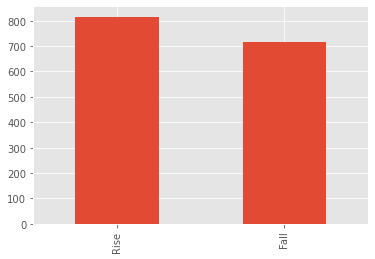

In [25]:
# Stock Data
# List of our Stocks
bioStock = ["FBRX", "TRIL", "CODX", "ALIM", "BTAI"]
pharmStock = ["ABT", "RCUS", "LLY", "ELAN", "MRK"]
techStocks = ["BILI", "CCOI", "CHT"]
energyStocks = ["CVX","XOM","KMI","WMB","LNG"]
retailStocks = ["WMT","AMZN","COST","BIG","ACI"]
consumerStaplesStocks= ['VDC', 'VCSAX']
utilityStocks= [ 'VUIAX', 'VPU']
realEstateStocks = ['AMT', 'PLD', 'EQIX', 'BAM', 'ZG']
healthCareStocks = ['JNJ', 'MDT', 'NVS', 'PFE', 'GSK']

tickerSymbol = bioStock + pharmStock + techStocks + energyStocks + retailStocks + consumerStaplesStocks + utilityStocks + realEstateStocks + healthCareStocks

# Extraction our Stock data
start = "2020-01-22"
end = dt.now()

stocks = pd.DataFrame()
sc_df = pd.DataFrame()


for i in tickerSymbol:
    df = web.DataReader(i, "yahoo", start, end)
    df.reset_index(inplace=True)

    weeklyPrice = df.groupby([pd.Grouper(key="Date", freq="W")]).mean()
    weeklyPrice["Stock"] = i
    weeklyPrice.reset_index(inplace=True)
    
    stocks = stocks.append(weeklyPrice[["Adj Close", "Date", "Stock"]],
                          ignore_index = True)
    stocks["stock_price_change"] = stocks["Adj Close"].diff().fillna(0)
    sc_df = pd.merge(stocks, weeklyCovid, on="Date")


sc_df.head()

#Labeling our Stocks by Category
sc_df["Category"] = ""
sc_df.loc[sc_df["Stock"].isin(bioStock), "Category"] = "biotech"
sc_df.loc[sc_df["Stock"].isin(pharmStock), "Category"] = "pharmacy"
sc_df.loc[sc_df["Stock"].isin(techStocks), "Category"] = "it"
sc_df.loc[sc_df["Stock"].isin(energyStocks), "Category"] = "energy"
sc_df.loc[sc_df["Stock"].isin(retailStocks), "Category"] = "retail"
sc_df.loc[sc_df["Stock"].isin(consumerStaplesStocks), "Category"] = "consumer"
sc_df.loc[sc_df["Stock"].isin(utilityStocks), "Category"] = "utility"
sc_df.loc[sc_df["Stock"].isin(realEstateStocks), "Category"] = "realEstate"
sc_df.loc[sc_df["Stock"].isin(healthCareStocks), "Category"] = "healthCare"

#Adding column with Category as number
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
sc_df["Category_Enc"] = lb_make.fit_transform(sc_df["Category"])
sc_df[["Category","Category_Enc"]].head(25)


#Labeling
sc_df["Rise/Fall"] = ""
sc_df.loc[sc_df["stock_price_change"]>0, "Rise/Fall"] = "Rise"
sc_df.loc[sc_df["stock_price_change"]<0, "Rise/Fall"] = "Fall"
sc_df.loc[sc_df["stock_price_change"]==0, "Rise/Fall"] = np.nan

sc_df.dropna(inplace=True)
sc_df.to_csv("Stocks.csv")

#Chart of Rise/fall
ax = sc_df["Rise/Fall"].value_counts().plot(kind = "bar")



In [26]:
sc_df.head(10)


,Adj Close,Date,Stock,stock_price_change,tot_cases,new_case,tot_death,new_death,case_change,death_change,Category,Category_Enc,Rise/Fall
1,3.996667,2020-01-26,TRIL,-30.650833,1,1.0,0,0.0,0.0,0.0,biotech,0,Fall
2,1.680000,2020-01-26,CODX,-11.930000,1,1.0,0,0.0,0.0,0.0,biotech,0,Fall
3,7.433333,2020-01-26,ALIM,-5.501667,1,1.0,0,0.0,0.0,0.0,biotech,0,Fall
4,17.196667,2020-01-26,BTAI,12.909167,1,1.0,0,0.0,0.0,0.0,biotech,0,Rise
5,89.964806,2020-01-26,ABT,34.377305,1,1.0,0,0.0,0.0,0.0,pharmacy,5,Rise
6,9.596667,2020-01-26,RCUS,-101.603332,1,1.0,0,0.0,0.0,0.0,pharmacy,5,Fall
7,137.849106,2020-01-26,LLY,115.436606,1,1.0,0,0.0,0.0,0.0,pharmacy,5,Rise
8,32.016666,2020-01-26,ELAN,-111.101631,1,1.0,0,0.0,0.0,0.0,pharmacy,5,Fall
9,86.027308,2020-01-26,MRK,55.494809,1,1.0,0,0.0,0.0,0.0,pharmacy,5,Rise
10,22.290000,2020-01-26,BILI,-58.355000,1,1.0,0,0.0,0.0,0.0,it,4,Fall


# Part 3: Choosing our features
The features we chose to use are the following:
- Stock Category: This is important to include because if we only had COVID data to inform us on if the stocks will rise or fall, then for a single week the model would have 37 (the number of stocks) identical inputs, and outputs of rise or fall. Adding the stock category creates some difference in the input between stocks. It may also help find patterns between stock types.
- Change in cases
- Change in deaths
- New Cases
- New Deaths

The output we are hoping to predict is whether the stocks will rise or fall

In [ ]:
# Features
features=["tot_cases", "case_change", "tot_death", "death_change"]